In [1]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import cv2 as cv
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    InterpolationMode,
)
from matplotlib import pyplot as plt

# HP
folder_name = 'siemens15k'
resolution = 512

In this notebbok we will explore the generation of the masks of the bbox.<br>
Half of thw work is already done, as we have both the images and the metadata with the bbox information.<br>

Original coordinates: [2320  803 2817 1156]
Laterality: R
Original size: (3518, 2800)
Reshape size: (512, 512, 3)
Flipped coordinates: [ 480  803  -17 1156]
Resized coordinates: [ 88 147   0 211]
Squared coordinates: [ 88  82   0 146]


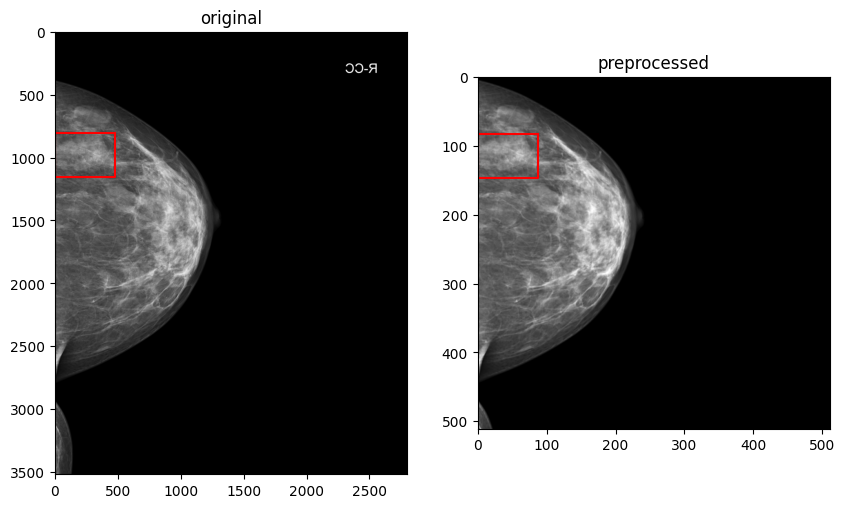

In [12]:
# read metadata file
metadata_path = repo_path / 'data/vindr-mammo/metadata'/f'finding_annotations.csv' 
metadata = pd.read_csv(metadata_path)
# remove rows with finding_caegories == "'No Finding'"
metadata = metadata[metadata['finding_categories'] != "['No Finding']"]

# example row
i = 1160

# get bbox
x1, y1, x2, y2 = metadata.xmin[i], metadata.ymin[i], metadata.xmax[i], metadata.ymax[i]
coord = np.asarray([x1, y1, x2, y2], dtype=int)
print(f'Original coordinates: {coord}')
# get laterality
side = metadata.laterality[i]
print(f'Laterality: {side}')

# add png extension
file_name = metadata.image_id[i] + '.png'
image_path = repo_path / 'data/vindr-mammo/images/' f'{folder_name}' / file_name
image_path_RGB = repo_path / 'data/vindr-mammo/images/' f'{folder_name}_RGB' / file_name

# read images
im = np.asarray(Image.open(image_path))
im_preprocessed = np.asarray(Image.open(image_path_RGB))

# images sizes
original_size = im.shape
reshape_size = im_preprocessed.shape
print(f'Original size: {original_size}\nReshape size: {reshape_size}')

# if side is right, flip x coordinate
if side == 'R':
    coord[0] =  original_size[1] - coord[0]# -1
    coord[2] =  original_size[1] - coord[2]# -1
    
    print(f'Flipped coordinates: {coord}')

coord = np.clip(coord, 0, None) # negative values are send to zero

# if any of the coordinates is negative, or the coordinates are zero, skip
if np.any(coord < 0) or (coord[0]-coord[2]) == 0:
    print('Skipping')

# get resized bounding box coordinates
orig_height = original_size[0]
orig_width = original_size[1]
# vector of coordinates
coord_r = (coord * (resolution / orig_width))
coord_r = np.round(coord_r).astype(int) # round to nearest int
print(f'Resized coordinates: {coord_r}')

# get the resized height and width difference before cropping to remove from y coordinates (the larger, height)
resize_diff = int((orig_height * resolution)/orig_width) - resolution
resize_diff = int(resize_diff/2)
# substract from y1 and y2
coord_r[1] = coord_r[1] - resize_diff
coord_r[3] = coord_r[3] - resize_diff
print(f'Squared coordinates: {coord_r}')

# plot original and preprocessed
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('original')
# plot the bbox
ax[0].plot([coord[0], coord[0], coord[2], coord[2], coord[0]], [coord[1], coord[3], coord[3], coord[1], coord[1]], color='r')
ax[1].imshow(im_preprocessed, cmap='gray')
ax[1].set_title('preprocessed')
# plot the bbox
ax[1].plot([coord_r[0], coord_r[0], coord_r[2], coord_r[2], coord_r[0]], [coord_r[1], coord_r[3], coord_r[3], coord_r[1], coord_r[1]], color='r')

Now that the bbox coordinates are available and computed, the next step is to generate the masks.<br>

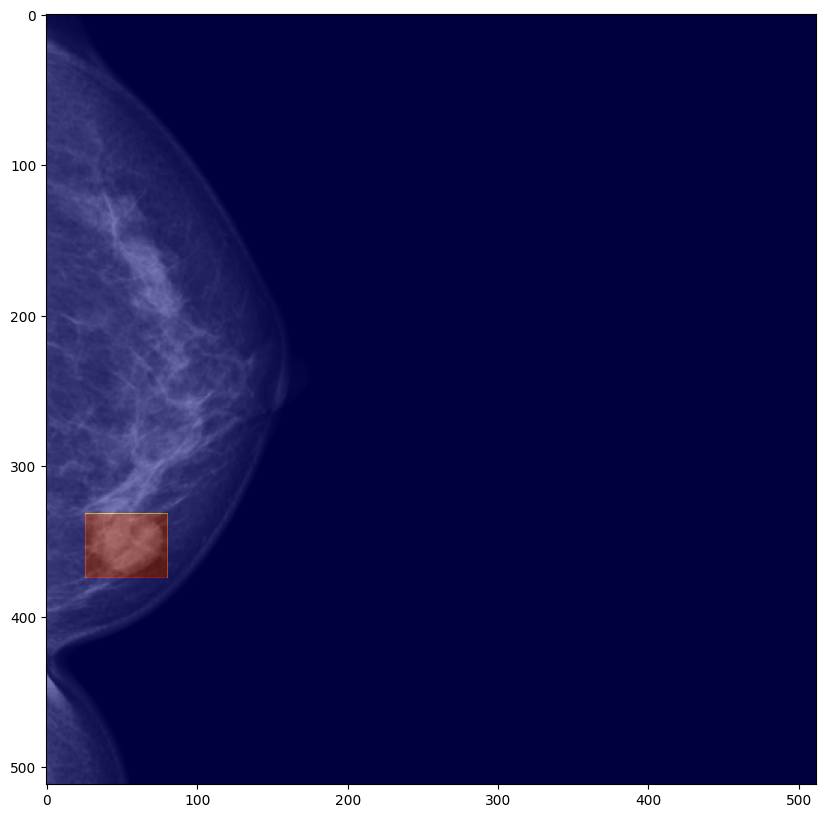

In [47]:
# create mask using pil
mask = Image.new('L', (resolution, resolution), 0) # creates empty 8-bit grayscale image
draw = ImageDraw.Draw(mask) # prepare drawing
# draw the rectangle using the coord_r
draw.rectangle([coord_r[0], coord_r[1], coord_r[2], coord_r[3]], fill=255) # fill with white
# convert to numpy array to plot together with the image
mask = np.array(mask)
# plot overlapping
plt.figure(figsize=(10,10))
plt.imshow(im_preprocessed, cmap='gray')
plt.imshow(mask, cmap='jet', alpha=0.5)

# Mask for inference

Original coordinates: [2320  803 2817 1156]
Laterality: R
Original size: (3518, 2800)
Reshape size: (512, 512, 3)
Flipped coordinates: [ 480  803  -17 1156]
Resized coordinates: [ 88 147   0 211]
Squared coordinates: [ 88  82   0 146]


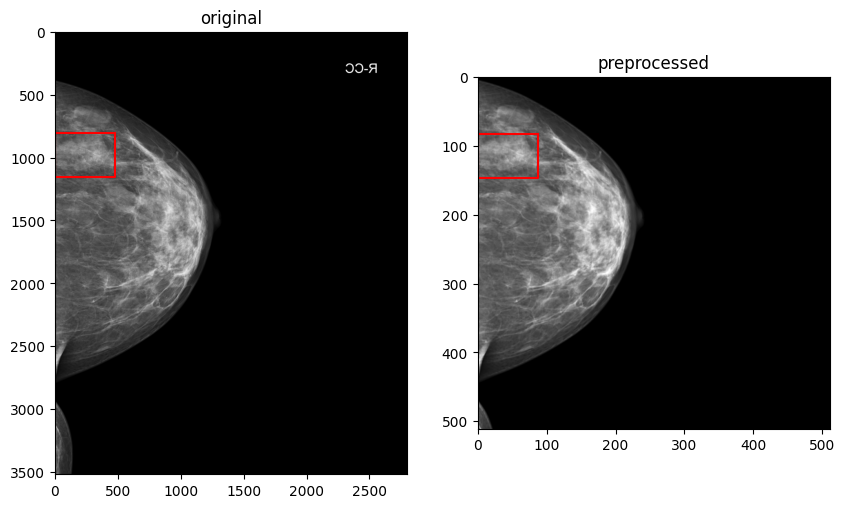

In [13]:
image_path = repo_path / 'data/vindr-mammo/images/siemens15k_RGB/0a55c283214f768716b7d91ff0388bd9.png'
data_saving_path = repo_path / 'experiments/inpainting/vindr-mammo/data'

# read image using pil
pil_image = Image.open(image_path).convert("RGB")
# create mask
mask = Image.new("L", pil_image.size, 0)
draw = ImageDraw.Draw(mask)
# draw small rectangle in the center
center = (pil_image.size[0] // 8, pil_image.size[1] // 1.5)
size = (pil_image.size[0] // 16, pil_image.size[1] // 16)
draw.rectangle(
            (center[0] - size[0] // 2, center[1] - size[1] // 2, center[0] + size[0] // 2, center[1] + size[1] // 2),
            fill=255,
        )
# plot image and mask overlapping
plt.figure()
plt.imshow(pil_image)
plt.imshow(mask, cmap='gray', alpha=0.5)

# save both images
pil_image.save(data_saving_path / 'pil_image.png')
mask.save(data_saving_path / 'mask.png')

# convert pil image to L mode
pil_image = pil_image.convert("L")
# save overklapping image
overlapped = Image.blend(pil_image, mask, 0.5)
overlapped.save(data_saving_path / 'overlapped.png')

# Healthy mask

First, get preprocessed mask

Original coordinates: [ 300 1361  375 1460]
Laterality: L
Original size: (3518, 2800)
Reshape size: (512, 512, 3)
Resized coordinates: [ 55 249  69 267]
Squared coordinates: [ 55 184  69 202]


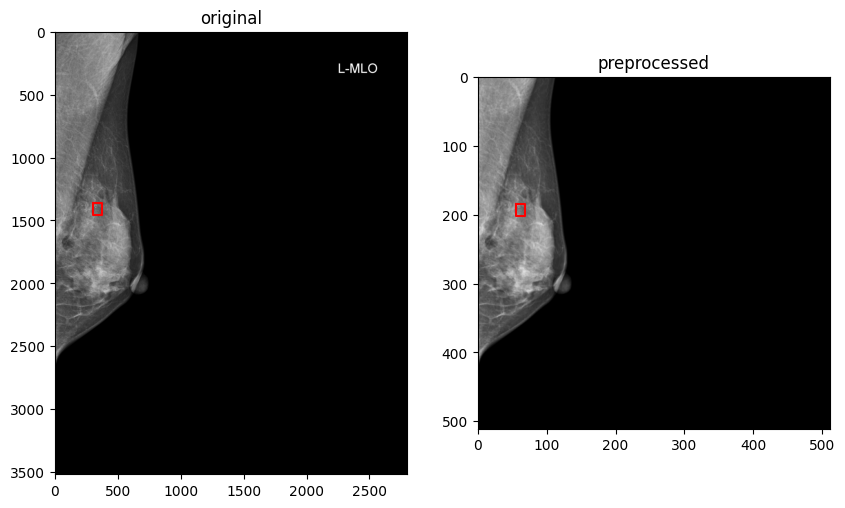

In [54]:
# read metadata file
metadata_path = repo_path / 'data/vindr-mammo/metadata'/f'finding_annotations.csv' 
metadata = pd.read_csv(metadata_path)
# remove rows with finding_caegories == "'No Finding'"
metadata = metadata[metadata['finding_categories'] != "['No Finding']"]

# example row
i = 116

# get bbox
x1, y1, x2, y2 = metadata.xmin[i], metadata.ymin[i], metadata.xmax[i], metadata.ymax[i]
coord = np.asarray([x1, y1, x2, y2], dtype=int)
print(f'Original coordinates: {coord}')
# get laterality
side = metadata.laterality[i]
print(f'Laterality: {side}')

# add png extension
file_name = metadata.image_id[i] + '.png'
image_path = repo_path / 'data/vindr-mammo/images/' f'{folder_name}' / file_name
image_path_RGB = repo_path / 'data/vindr-mammo/images/' f'{folder_name}_RGB' / file_name

# read images
im = np.asarray(Image.open(image_path))
im_preprocessed = np.asarray(Image.open(image_path_RGB))

# images sizes
original_size = im.shape
reshape_size = im_preprocessed.shape
print(f'Original size: {original_size}\nReshape size: {reshape_size}')

# if side is right, flip x coordinate
if side == 'R':
    coord[0] =  original_size[1] - coord[0]# -1
    coord[2] =  original_size[1] - coord[2]# -1
    
    print(f'Flipped coordinates: {coord}')

coord = np.clip(coord, 0, None) # negative values are send to zero

# if any of the coordinates is negative, or the coordinates are zero, skip
if np.any(coord < 0) or (coord[0]-coord[2]) == 0:
    print('Skipping')

# get resized bounding box coordinates
orig_height = original_size[0]
orig_width = original_size[1]
# vector of coordinates
coord_r = (coord * (resolution / orig_width))
coord_r = np.round(coord_r).astype(int) # round to nearest int
print(f'Resized coordinates: {coord_r}')

# get the resized height and width difference before cropping to remove from y coordinates (the larger, height)
resize_diff = int((orig_height * resolution)/orig_width) - resolution
resize_diff = int(resize_diff/2)
# substract from y1 and y2
coord_r[1] = coord_r[1] - resize_diff
coord_r[3] = coord_r[3] - resize_diff
print(f'Squared coordinates: {coord_r}')

# plot original and preprocessed
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('original')
# plot the bbox
ax[0].plot([coord[0], coord[0], coord[2], coord[2], coord[0]], [coord[1], coord[3], coord[3], coord[1], coord[1]], color='r')
ax[1].imshow(im_preprocessed, cmap='gray')
ax[1].set_title('preprocessed')
# plot the bbox
ax[1].plot([coord_r[0], coord_r[0], coord_r[2], coord_r[2], coord_r[0]], [coord_r[1], coord_r[3], coord_r[3], coord_r[1], coord_r[1]], color='r')

# create mask using pil
mask = Image.new('L', (resolution, resolution), 0) # creates empty 8-bit grayscale image
draw = ImageDraw.Draw(mask) # prepare drawing
# draw the rectangle using the coord_r
draw.rectangle([coord_r[0], coord_r[1], coord_r[2], coord_r[3]], fill=255) # fill with white

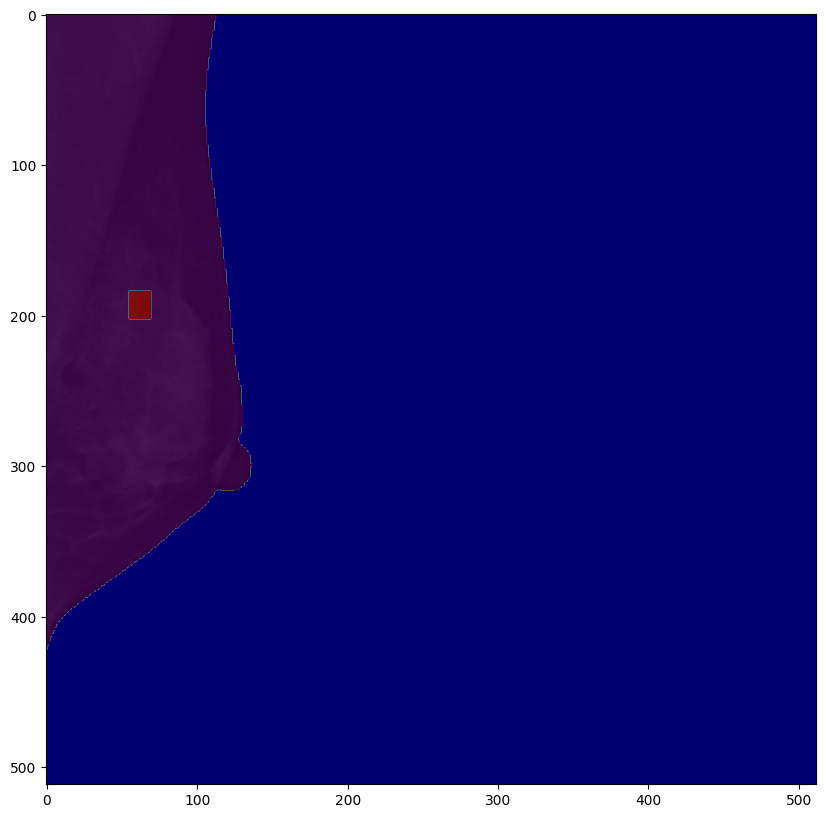

In [55]:
# first a mask of the whole breast is created using the 0 pixel value as threshold
breast_mask = im_preprocessed[:,:,0] > 0
breast_mask = breast_mask.astype(int) * 255
# plot
plt.figure(figsize=(10,10))
plt.imshow(im_preprocessed, cmap='gray')
plt.imshow(breast_mask, cmap='jet', alpha=0.8)
plt.imshow(mask, cmap='jet', alpha=0.5)

In [56]:
def create_right_mask(coord_r, breast_mask):
    """creates a mask on the right side of the lesion mask

    Args:
        coord_r (np.array): coordinates of the original mask

    Returns:
        PIL.Image or None: mask on the right or None if not possible
    """
    x1, y1, x2, y2 = coord_r
    h_x1 = max(x1, x2)
    h_y_center = (y1 + y2) // 2
    h_y1 = h_y_center - 25
    h_y2 = h_y_center + 25
    h_coord = np.asarray([h_x1, h_y1, h_x1+50, h_y2], dtype=int)

    
    # if any of the coordinates is negative, return None
    if np.any(h_coord < 0):
        return None

    # use pil to create mask
    h_mask = Image.new('L', (resolution, resolution), 0) # creates empty 8-bit grayscale image
    draw = ImageDraw.Draw(h_mask) # prepare drawing
    # draw the rectangle using the h_coord
    draw.rectangle([h_coord[0], h_coord[1], h_coord[2], h_coord[3]], fill=255) # fill with white

    return h_mask